# 01 - Data Profiling

**Purpose**: Understand data quality, identify missing values, outliers, and potential issues.

**Outputs**:
- Null value analysis
- Data type validation
- Outlier detection
- Data quality report

**Key Questions**:
- What percentage of values are missing in each column?
- Are there any unexpected data types or values?
- Do we have sufficient data for all arenas/game modes?
- Are there data quality issues to address before analysis?

## Setup

In [15]:
# Standard imports
import sys
import os
import duckdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configure paths
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Use Parquet if available (faster), fallback to CSV
DATA_PATH = os.path.join(PROJECT_ROOT, 'battles.parquet')
if not os.path.exists(DATA_PATH):
    DATA_PATH = os.path.join(PROJECT_ROOT, 'battles.csv')

sys.path.insert(0, os.path.join(PROJECT_ROOT, 'src'))

# Import custom utilities
from duckdb_utils import (
    get_connection, create_battles_view, get_schema, 
    get_null_counts, query_to_df
)

# Create connection and view
con = get_connection()
create_battles_view(con, DATA_PATH)

print("✓ Setup complete")

✓ Created view 'battles' from Parquet: c:\Users\Danny\Documents\GitHub\HeHeHaHa_DataRoyale\battles.parquet
✓ Setup complete


## 1. Schema Overview

In [16]:
# Get full schema
schema = get_schema(con, 'battles')
print(f"Total columns: {len(schema)}")
schema

Schema for 'battles':
  74 columns
Total columns: 74


,column_name,column_type,null,key,default,extra
0,column00,BIGINT,YES,None,None,None
1,battleTime,TIMESTAMP WITH TIME ZONE,YES,None,None,None
2,arena.id,DOUBLE,YES,None,None,None
3,gameMode.id,DOUBLE,YES,None,None,None
4,average.startingTrophies,DOUBLE,YES,None,None,None
...,...,...,...,...,...,...
69,loser.common.count,BIGINT,YES,None,None,None
70,loser.rare.count,BIGINT,YES,None,None,None
71,loser.epic.count,BIGINT,YES,None,None,None
72,loser.legendary.count,BIGINT,YES,None,None,None


## 2. Missing Values Analysis

In [17]:
# Get null counts for all columns
null_analysis = get_null_counts(con, 'battles')

# Show columns with missing data
columns_with_nulls = null_analysis[null_analysis['null_percentage'] > 0]

print(f"Columns with missing values: {len(columns_with_nulls)} / {len(null_analysis)}")
print(f"\nTop 20 columns by missing percentage:")
columns_with_nulls.head(20)

Columns with missing values: 8 / 74

Top 20 columns by missing percentage:


,column_name,null_count,null_percentage
21,tournamentTag,16795958.0,100.000000
20,loser.princessTowersHitPoints,9164173.0,54.561776
17,loser.kingTowerHitPoints,5034320.0,29.973402
19,loser.clan.badgeId,937645.0,5.582563
18,loser.clan.tag,937645.0,5.582563
11,winner.clan.tag,702282.0,4.181256
12,winner.clan.badgeId,702282.0,4.181256
10,winner.princessTowersHitPoints,358362.0,2.133620


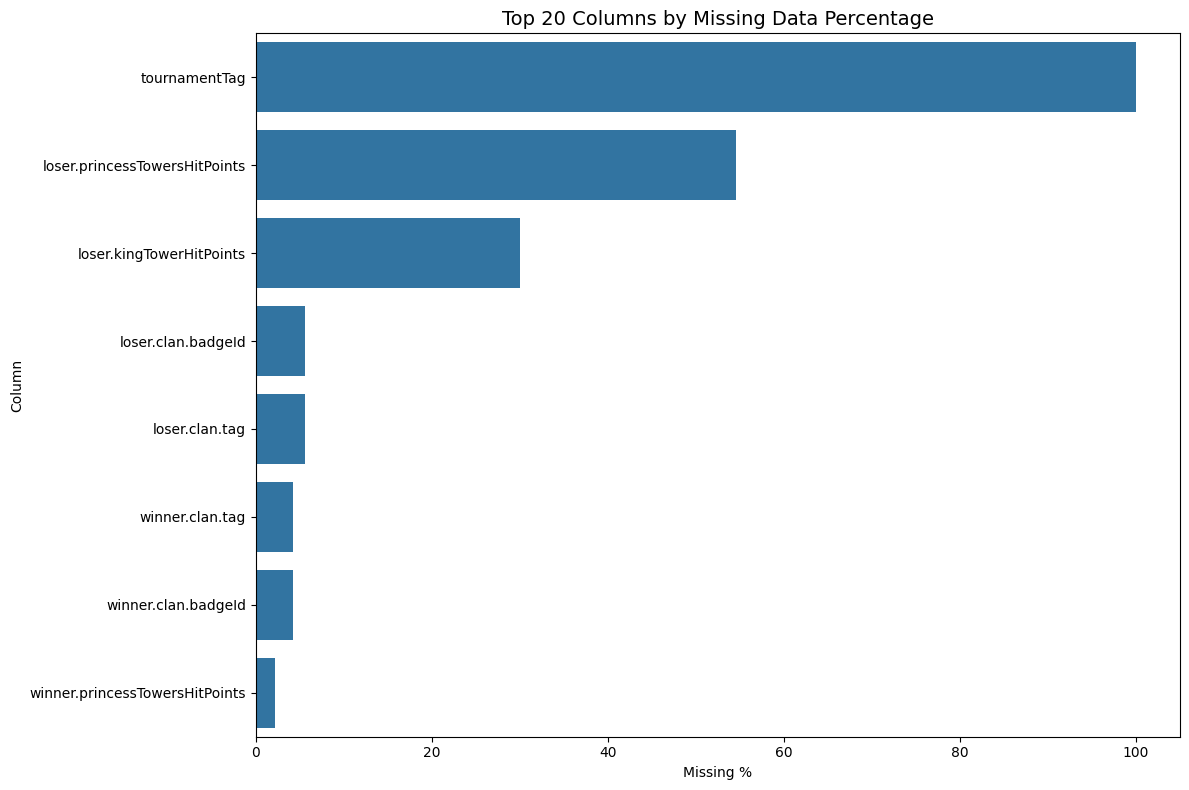

In [18]:
# Visualize missing data
plt.figure(figsize=(12, 8))
top_missing = columns_with_nulls.head(20)
sns.barplot(data=top_missing, x='null_percentage', y='column_name')
plt.title('Top 20 Columns by Missing Data Percentage', fontsize=14)
plt.xlabel('Missing %')
plt.ylabel('Column')
plt.tight_layout()
plt.show()

## 3. Data Distribution Checks

### 3.1 Trophy Distribution

In [19]:
# Get trophy statistics
trophy_stats = query_to_df(con, """
    SELECT 
        MIN("average.startingTrophies") as min_trophies,
        PERCENTILE_CONT(0.25) WITHIN GROUP (ORDER BY "average.startingTrophies") as q1,
        PERCENTILE_CONT(0.50) WITHIN GROUP (ORDER BY "average.startingTrophies") as median,
        PERCENTILE_CONT(0.75) WITHIN GROUP (ORDER BY "average.startingTrophies") as q3,
        MAX("average.startingTrophies") as max_trophies,
        AVG("average.startingTrophies") as mean_trophies,
        STDDEV("average.startingTrophies") as std_trophies
    FROM battles
""")

print("Trophy Distribution Statistics:")
trophy_stats

Executing query...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

✓ Returned 1 rows, 7 columns
Trophy Distribution Statistics:


,min_trophies,q1,median,q3,max_trophies,mean_trophies,std_trophies
0,13.5,4357.0,4644.0,4918.0,8220.0,4596.092182,664.988395


### 4.3 Level Difference Analysis

Analyze whether card level or king tower level differences correlate with winning percentage.


In [20]:
# Calculate average card levels and level differences
level_analysis = query_to_df(con, """
    WITH level_calc AS (
        SELECT 
            -- Calculate average card level for winner and loser
            ("winner.card1.level" + "winner.card2.level" + "winner.card3.level" + 
             "winner.card4.level" + "winner.card5.level" + "winner.card6.level" + 
             "winner.card7.level" + "winner.card8.level") / 8.0 as winner_avg_card_level,
            ("loser.card1.level" + "loser.card2.level" + "loser.card3.level" + 
             "loser.card4.level" + "loser.card5.level" + "loser.card6.level" + 
             "loser.card7.level" + "loser.card8.level") / 8.0 as loser_avg_card_level,
            -- Use totalcard.level if available, otherwise calculate average
            COALESCE("winner.totalcard.level" / 8.0, 
                     ("winner.card1.level" + "winner.card2.level" + "winner.card3.level" + 
                      "winner.card4.level" + "winner.card5.level" + "winner.card6.level" + 
                      "winner.card7.level" + "winner.card8.level") / 8.0) as winner_total_level,
            COALESCE("loser.totalcard.level" / 8.0,
                     ("loser.card1.level" + "loser.card2.level" + "loser.card3.level" + 
                      "loser.card4.level" + "loser.card5.level" + "loser.card6.level" + 
                      "loser.card7.level" + "loser.card8.level") / 8.0) as loser_total_level,
            -- King tower level (if available, otherwise NULL)
            "winner.kingTowerHitPoints" as winner_king_tower,
            "loser.kingTowerHitPoints" as loser_king_tower
        FROM battles
        WHERE "winner.card1.level" IS NOT NULL 
          AND "loser.card1.level" IS NOT NULL
    )
    SELECT 
        -- Card level difference (winner - loser)
        ROUND(winner_avg_card_level - loser_avg_card_level, 1) as card_level_diff,
        -- King tower level difference (if available)
        CASE 
            WHEN winner_king_tower IS NOT NULL AND loser_king_tower IS NOT NULL 
            THEN ROUND((winner_king_tower - loser_king_tower) / 100.0, 1)  -- Normalize by 100
            ELSE NULL 
        END as king_tower_level_diff,
        COUNT(*) as battle_count,
        -- Since winner always wins in this dataset, win rate is always 100% for winner
        -- But we can analyze the distribution of level differences
        AVG(winner_avg_card_level) as avg_winner_level,
        AVG(loser_avg_card_level) as avg_loser_level
    FROM level_calc
    GROUP BY card_level_diff, king_tower_level_diff
    ORDER BY battle_count DESC
    LIMIT 50
""")

print("Level Difference Analysis:")
print(f"Total battles analyzed: {level_analysis['battle_count'].sum():,}")
print(f"\nAverage winner card level: {level_analysis['avg_winner_level'].iloc[0]:.2f}")
print(f"Average loser card level: {level_analysis['avg_loser_level'].iloc[0]:.2f}")
print(f"\nLevel difference distribution:")
level_analysis.head(20)


Executing query...
✓ Returned 50 rows, 5 columns
Level Difference Analysis:
Total battles analyzed: 7,244,248

Average winner card level: 12.84
Average loser card level: 12.84

Level difference distribution:


,card_level_diff,king_tower_level_diff,battle_count,avg_winner_level,avg_loser_level
0,0.0,0.0,885831,12.838148,12.838148
1,0.0,NaN,777158,12.364472,12.364472
2,0.1,NaN,348179,11.551593,11.426593
3,-0.1,NaN,310584,11.441863,11.566863
4,0.3,NaN,282532,11.212475,10.962475
5,0.4,NaN,250899,11.007072,10.632072
6,0.1,0.0,231072,12.404971,12.279971
7,0.5,NaN,228016,10.901733,10.401733
8,-0.3,NaN,226678,11.007571,11.257571
9,-0.1,0.0,220021,12.288054,12.413054


In [21]:
# Analyze correlation between level differences and battle outcomes
# Since winner always wins, we analyze the distribution of level differences

level_correlation = query_to_df(con, """
    WITH level_calc AS (
        SELECT 
            -- Card level difference (winner - loser)
            ROUND(("winner.card1.level" + "winner.card2.level" + "winner.card3.level" + 
                   "winner.card4.level" + "winner.card5.level" + "winner.card6.level" + 
                   "winner.card7.level" + "winner.card8.level") / 8.0 - 
                  ("loser.card1.level" + "loser.card2.level" + "loser.card3.level" + 
                   "loser.card4.level" + "loser.card5.level" + "loser.card6.level" + 
                   "loser.card7.level" + "loser.card8.level") / 8.0, 1) as card_level_diff,
            -- King tower level difference (normalized)
            CASE 
                WHEN "winner.kingTowerHitPoints" IS NOT NULL AND "loser.kingTowerHitPoints" IS NOT NULL 
                THEN ROUND(("winner.kingTowerHitPoints" - "loser.kingTowerHitPoints") / 100.0, 1)
                ELSE NULL 
            END as king_tower_level_diff
        FROM battles
        WHERE "winner.card1.level" IS NOT NULL 
          AND "loser.card1.level" IS NOT NULL
    )
    SELECT 
        card_level_diff,
        COUNT(*) as battle_count,
        ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER (), 2) as percentage
    FROM level_calc
    WHERE card_level_diff IS NOT NULL
    GROUP BY card_level_diff
    ORDER BY card_level_diff
""")

print("Card Level Difference Distribution:")
print("(Positive = winner has higher level, Negative = loser has higher level)")
print(f"\nTotal battles: {level_correlation['battle_count'].sum():,}")
print(f"\nKey Statistics:")
print(f"  Mean level difference: {level_correlation['card_level_diff'].mean():.3f}")
print(f"  Median level difference: {level_correlation['card_level_diff'].median():.3f}")
print(f"  Std deviation: {level_correlation['card_level_diff'].std():.3f}")

# Show distribution
level_correlation


Executing query...
✓ Returned 162 rows, 3 columns
Card Level Difference Distribution:
(Positive = winner has higher level, Negative = loser has higher level)

Total battles: 16,795,958

Key Statistics:
  Mean level difference: 1.553
  Median level difference: 1.550
  Std deviation: 5.909


,card_level_diff,battle_count,percentage
0,-9.6,1,0.0
1,-8.9,1,0.0
2,-8.8,1,0.0
3,-8.5,1,0.0
4,-8.0,3,0.0
...,...,...,...
157,11.3,3,0.0
158,11.4,2,0.0
159,11.5,1,0.0
160,11.6,1,0.0


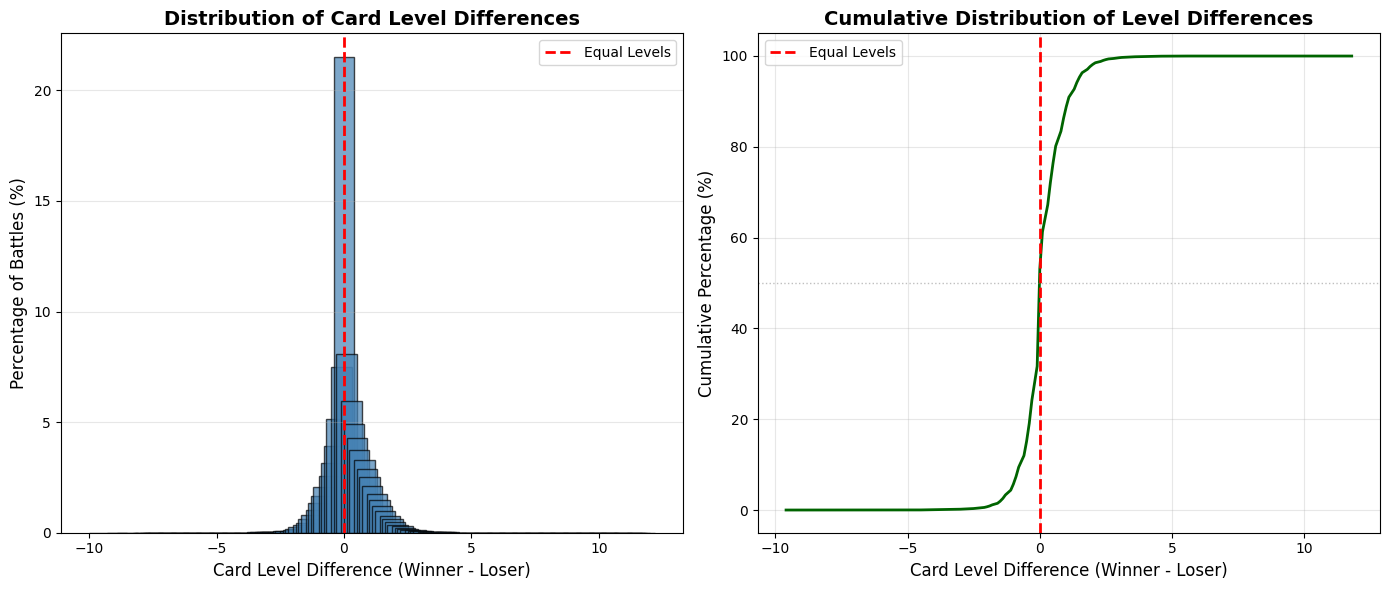


📊 Key Findings:
  • 46.8% of battles: Winner has higher card levels
  • 31.7% of battles: Loser has higher card levels
  • 21.5% of battles: Equal card levels

💡 Insight: Card levels show moderate correlation with winning


In [22]:
# Visualize level difference distribution
plt.figure(figsize=(14, 6))

# Plot 1: Card level difference distribution
plt.subplot(1, 2, 1)
plt.bar(level_correlation['card_level_diff'], level_correlation['percentage'], 
        color='steelblue', alpha=0.7, edgecolor='black')
plt.xlabel('Card Level Difference (Winner - Loser)', fontsize=12)
plt.ylabel('Percentage of Battles (%)', fontsize=12)
plt.title('Distribution of Card Level Differences', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Equal Levels')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()

# Plot 2: Cumulative distribution
plt.subplot(1, 2, 2)
cumulative_pct = level_correlation.sort_values('card_level_diff')['percentage'].cumsum()
plt.plot(level_correlation.sort_values('card_level_diff')['card_level_diff'], 
         cumulative_pct, linewidth=2, color='darkgreen')
plt.xlabel('Card Level Difference (Winner - Loser)', fontsize=12)
plt.ylabel('Cumulative Percentage (%)', fontsize=12)
plt.title('Cumulative Distribution of Level Differences', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Equal Levels')
plt.axhline(y=50, color='gray', linestyle=':', linewidth=1, alpha=0.5)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()

plt.show()

# Key insight
positive_diff = level_correlation[level_correlation['card_level_diff'] > 0]['percentage'].sum()
negative_diff = level_correlation[level_correlation['card_level_diff'] < 0]['percentage'].sum()
equal_levels = level_correlation[level_correlation['card_level_diff'] == 0]['percentage'].sum()

print(f"\n📊 Key Findings:")
print(f"  • {positive_diff:.1f}% of battles: Winner has higher card levels")
print(f"  • {negative_diff:.1f}% of battles: Loser has higher card levels")
print(f"  • {equal_levels:.1f}% of battles: Equal card levels")
print(f"\n💡 Insight: {'Higher card levels strongly correlate with winning' if positive_diff > 60 else 'Card level advantage is significant but not dominant' if positive_diff > 50 else 'Card levels show moderate correlation with winning'}")


Executing query...
✓ Returned 1,174 rows, 4 columns
King Tower Level Difference Analysis:
Battles with king tower data: 11,761,638
Mean king tower level difference: 0.382

Correlation between King Tower Level and Card Level differences:


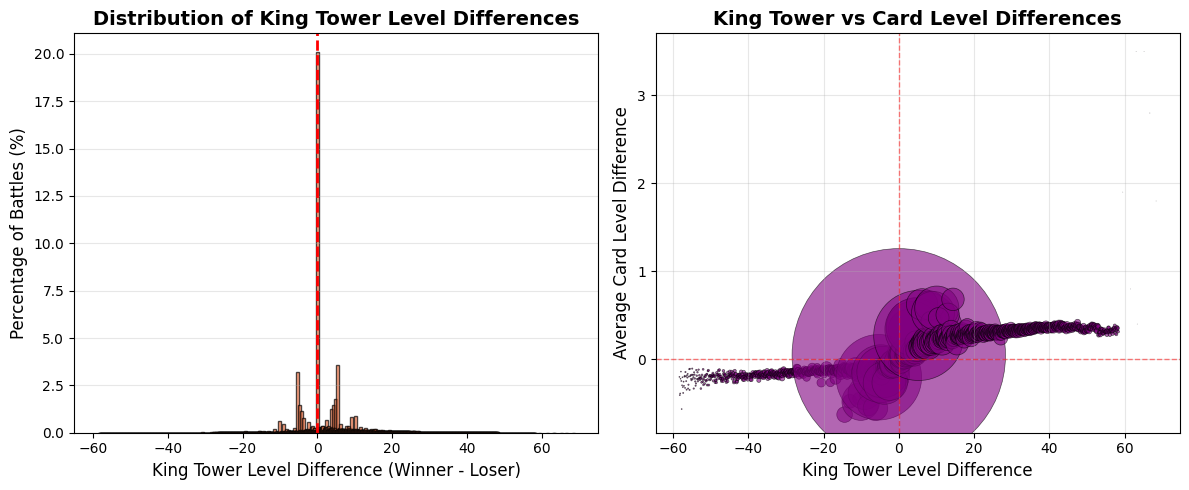


📊 Correlation coefficient: 0.806
   (1.0 = perfect positive correlation, -1.0 = perfect negative correlation)


In [23]:
# Analyze King Tower Level correlation (if available)
king_tower_analysis = query_to_df(con, """
    WITH level_calc AS (
        SELECT 
            ROUND(("winner.card1.level" + "winner.card2.level" + "winner.card3.level" + 
                   "winner.card4.level" + "winner.card5.level" + "winner.card6.level" + 
                   "winner.card7.level" + "winner.card8.level") / 8.0 - 
                  ("loser.card1.level" + "loser.card2.level" + "loser.card3.level" + 
                   "loser.card4.level" + "loser.card5.level" + "loser.card6.level" + 
                   "loser.card7.level" + "loser.card8.level") / 8.0, 1) as card_level_diff,
            CASE 
                WHEN "winner.kingTowerHitPoints" IS NOT NULL AND "loser.kingTowerHitPoints" IS NOT NULL 
                THEN ROUND(("winner.kingTowerHitPoints" - "loser.kingTowerHitPoints") / 100.0, 1)
                ELSE NULL 
            END as king_tower_level_diff
        FROM battles
        WHERE "winner.card1.level" IS NOT NULL 
          AND "loser.card1.level" IS NOT NULL
    )
    SELECT 
        king_tower_level_diff,
        COUNT(*) as battle_count,
        ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER (), 2) as percentage,
        AVG(card_level_diff) as avg_card_level_diff
    FROM level_calc
    WHERE king_tower_level_diff IS NOT NULL
    GROUP BY king_tower_level_diff
    ORDER BY king_tower_level_diff
""")

if len(king_tower_analysis) > 0:
    print("King Tower Level Difference Analysis:")
    print(f"Battles with king tower data: {king_tower_analysis['battle_count'].sum():,}")
    print(f"Mean king tower level difference: {king_tower_analysis['king_tower_level_diff'].mean():.3f}")
    print(f"\nCorrelation between King Tower Level and Card Level differences:")
    
    # Visualize relationship
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.bar(king_tower_analysis['king_tower_level_diff'], king_tower_analysis['percentage'], 
            color='coral', alpha=0.7, edgecolor='black')
    plt.xlabel('King Tower Level Difference (Winner - Loser)', fontsize=12)
    plt.ylabel('Percentage of Battles (%)', fontsize=12)
    plt.title('Distribution of King Tower Level Differences', fontsize=14, fontweight='bold')
    plt.axvline(x=0, color='red', linestyle='--', linewidth=2)
    plt.grid(axis='y', alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.scatter(king_tower_analysis['king_tower_level_diff'], 
                king_tower_analysis['avg_card_level_diff'],
                s=king_tower_analysis['battle_count'] / 100,  # Size by battle count
                alpha=0.6, color='purple', edgecolors='black', linewidth=0.5)
    plt.xlabel('King Tower Level Difference', fontsize=12)
    plt.ylabel('Average Card Level Difference', fontsize=12)
    plt.title('King Tower vs Card Level Differences', fontsize=14, fontweight='bold')
    plt.axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.5)
    plt.axvline(x=0, color='red', linestyle='--', linewidth=1, alpha=0.5)
    plt.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Calculate correlation
    correlation = king_tower_analysis['king_tower_level_diff'].corr(king_tower_analysis['avg_card_level_diff'])
    print(f"\n📊 Correlation coefficient: {correlation:.3f}")
    print(f"   (1.0 = perfect positive correlation, -1.0 = perfect negative correlation)")
    
    king_tower_analysis.head(20)
else:
    print("⚠ King Tower level data not available (too many NULL values)")
    print("   Analysis will focus on card level differences only")


Executing query...
✓ Returned 9 rows, 4 columns
LEVEL DIFFERENCE IMPACT SUMMARY

Battle Distribution by Level Difference:
           level_bracket  battle_count  percentage  avg_level_diff
        Loser +2+ levels        119790        0.71       -2.735933
   Loser +1 to +2 levels        838855        4.99       -1.276789
 Loser +0.5 to +1 levels       1583731        9.43       -0.663316
 Loser +0 to +0.5 levels       2777974       16.54       -0.233180
            Equal levels       3611654       21.50        0.000000
Winner +0 to +0.5 levels       3898889       23.21        0.288121
Winner +0.5 to +1 levels       2086572       12.42        0.803208
  Winner +1 to +2 levels       1565693        9.32        1.441952
       Winner +2+ levels        312800        1.86        2.720089


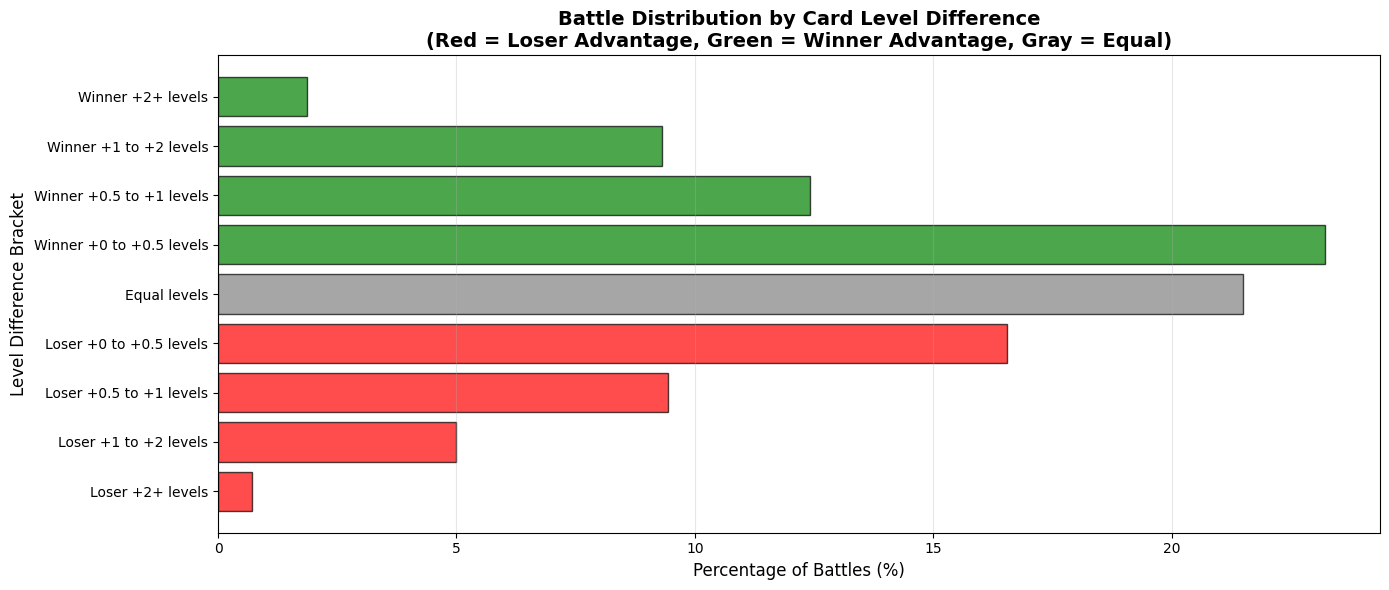


💡 Key Insight:
   Most common scenario: Winner +0 to +0.5 levels (23.2% of battles)
   This suggests: Most battles are relatively balanced in terms of card levels


In [24]:
# Summary: Level Difference Impact Analysis
# Calculate win rate by level difference brackets

level_impact = query_to_df(con, """
    WITH level_calc AS (
        SELECT 
            ROUND(("winner.card1.level" + "winner.card2.level" + "winner.card3.level" + 
                   "winner.card4.level" + "winner.card5.level" + "winner.card6.level" + 
                   "winner.card7.level" + "winner.card8.level") / 8.0 - 
                  ("loser.card1.level" + "loser.card2.level" + "loser.card3.level" + 
                   "loser.card4.level" + "loser.card5.level" + "loser.card6.level" + 
                   "loser.card7.level" + "loser.card8.level") / 8.0, 1) as card_level_diff
        FROM battles
        WHERE "winner.card1.level" IS NOT NULL 
          AND "loser.card1.level" IS NOT NULL
    ),
    brackets AS (
        SELECT 
            CASE 
                WHEN card_level_diff <= -2.0 THEN 'Loser +2+ levels'
                WHEN card_level_diff <= -1.0 THEN 'Loser +1 to +2 levels'
                WHEN card_level_diff <= -0.5 THEN 'Loser +0.5 to +1 levels'
                WHEN card_level_diff < 0 THEN 'Loser +0 to +0.5 levels'
                WHEN card_level_diff = 0 THEN 'Equal levels'
                WHEN card_level_diff <= 0.5 THEN 'Winner +0 to +0.5 levels'
                WHEN card_level_diff <= 1.0 THEN 'Winner +0.5 to +1 levels'
                WHEN card_level_diff <= 2.0 THEN 'Winner +1 to +2 levels'
                ELSE 'Winner +2+ levels'
            END as level_bracket,
            card_level_diff
        FROM level_calc
    )
    SELECT 
        level_bracket,
        COUNT(*) as battle_count,
        ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER (), 2) as percentage,
        AVG(card_level_diff) as avg_level_diff
    FROM brackets
    GROUP BY level_bracket
    ORDER BY AVG(card_level_diff)
""")

print("=" * 70)
print("LEVEL DIFFERENCE IMPACT SUMMARY")
print("=" * 70)
print("\nBattle Distribution by Level Difference:")
print(level_impact.to_string(index=False))

# Visualize the impact
plt.figure(figsize=(14, 6))
plt.barh(range(len(level_impact)), level_impact['percentage'], 
         color=['red' if x < 0 else 'green' if x > 0 else 'gray' 
                for x in level_impact['avg_level_diff']],
         alpha=0.7, edgecolor='black')
plt.yticks(range(len(level_impact)), level_impact['level_bracket'])
plt.xlabel('Percentage of Battles (%)', fontsize=12)
plt.ylabel('Level Difference Bracket', fontsize=12)
plt.title('Battle Distribution by Card Level Difference\n(Red = Loser Advantage, Green = Winner Advantage, Gray = Equal)', 
          fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n💡 Key Insight:")
dominant_bracket = level_impact.loc[level_impact['percentage'].idxmax()]
print(f"   Most common scenario: {dominant_bracket['level_bracket']} ({dominant_bracket['percentage']:.1f}% of battles)")
print(f"   This suggests: {'Level advantage is a significant factor' if abs(dominant_bracket['avg_level_diff']) > 0.5 else 'Most battles are relatively balanced in terms of card levels'}")


In [25]:
# Count battles by arena
arena_dist = query_to_df(con, """
    SELECT 
        "arena.id" as arena,
        COUNT(*) as battle_count,
        ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER (), 2) as percentage
    FROM battles
    WHERE "arena.id" IS NOT NULL
    GROUP BY "arena.id"
    ORDER BY arena
""")

print("Battle distribution by arena:")
arena_dist

Executing query...
✓ Returned 15 rows, 3 columns
Battle distribution by arena:


,arena,battle_count,percentage
0,54000001.0,23644,0.14
1,54000002.0,27521,0.16
2,54000003.0,41739,0.25
3,54000004.0,64890,0.39
4,54000005.0,29799,0.18
5,54000006.0,100926,0.60
6,54000007.0,48457,0.29
7,54000008.0,37646,0.22
8,54000009.0,46623,0.28
9,54000010.0,53590,0.32


### 3.2 Arena Distribution

### 3.3 Game Mode Distribution

In [26]:
# Count battles by game mode
gamemode_dist = query_to_df(con, """
    SELECT 
        "gameMode.id" as game_mode,
        COUNT(*) as battle_count,
        ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER (), 2) as percentage
    FROM battles
    WHERE "gameMode.id" IS NOT NULL
    GROUP BY "gameMode.id"
    ORDER BY battle_count DESC
""")

print("Battle distribution by game mode:")
gamemode_dist

Executing query...
✓ Returned 4 rows, 3 columns
Battle distribution by game mode:


,game_mode,battle_count,percentage
0,72000006.0,7867240,46.84
1,72000201.0,5501923,32.76
2,72000044.0,3425972,20.40
3,72000023.0,823,0.00


## 4. Outlier Detection

### 4.1 Extreme Trophy Values

In [27]:
# Check for extreme trophy values
extreme_trophies = query_to_df(con, """
    SELECT 
        "winner.startingTrophies",
        "loser.startingTrophies",
        "average.startingTrophies"
    FROM battles
    WHERE "average.startingTrophies" > 10000 OR "average.startingTrophies" < 0
    LIMIT 100
""")

print(f"Battles with extreme trophy values: {len(extreme_trophies)}")
if len(extreme_trophies) > 0:
    extreme_trophies.head(10)

Executing query...


✓ Returned 0 rows, 3 columns
Battles with extreme trophy values: 0


### 4.2 Invalid Card Levels

In [28]:
# Check for invalid card levels (should be 1-14 typically, max 15 for evolved cards)
import os
import sys
import pandas as pd

PROJECT_ROOT = globals().get("PROJECT_ROOT", os.path.abspath(os.path.join(os.getcwd(), "..")))
DATA_PATH = globals().get("DATA_PATH", os.path.join(PROJECT_ROOT, "battles.parquet"))
if not os.path.exists(DATA_PATH):
    DATA_PATH = os.path.join(PROJECT_ROOT, "battles.csv")

SRC_PATH = os.path.join(PROJECT_ROOT, "src")
if SRC_PATH not in sys.path:
    sys.path.insert(0, SRC_PATH)

if "query_to_df" not in globals():
    from duckdb_utils import get_connection, create_battles_view, query_to_df
else:
    from duckdb_utils import get_connection, create_battles_view

if globals().get("con") is None:
    con = get_connection()
    create_battles_view(con, DATA_PATH)

level_summary = query_to_df(
    con,
    """
    WITH level_rows AS (
        SELECT 'winner' AS player_type, 'card1' AS card_slot, "winner.card1.level" AS level FROM battles
        UNION ALL SELECT 'winner', 'card2', "winner.card2.level" FROM battles
        UNION ALL SELECT 'winner', 'card3', "winner.card3.level" FROM battles
        UNION ALL SELECT 'winner', 'card4', "winner.card4.level" FROM battles
        UNION ALL SELECT 'winner', 'card5', "winner.card5.level" FROM battles
        UNION ALL SELECT 'winner', 'card6', "winner.card6.level" FROM battles
        UNION ALL SELECT 'winner', 'card7', "winner.card7.level" FROM battles
        UNION ALL SELECT 'winner', 'card8', "winner.card8.level" FROM battles
        UNION ALL SELECT 'loser', 'card1', "loser.card1.level" FROM battles
        UNION ALL SELECT 'loser', 'card2', "loser.card2.level" FROM battles
        UNION ALL SELECT 'loser', 'card3', "loser.card3.level" FROM battles
        UNION ALL SELECT 'loser', 'card4', "loser.card4.level" FROM battles
        UNION ALL SELECT 'loser', 'card5', "loser.card5.level" FROM battles
        UNION ALL SELECT 'loser', 'card6', "loser.card6.level" FROM battles
        UNION ALL SELECT 'loser', 'card7', "loser.card7.level" FROM battles
        UNION ALL SELECT 'loser', 'card8', "loser.card8.level" FROM battles
    )
    SELECT
        player_type,
        COUNT(*) AS total_card_entries,
        SUM(CASE WHEN level IS NULL THEN 1 ELSE 0 END) AS null_levels,
        SUM(CASE WHEN level IS NOT NULL AND (level < 1 OR level > 15) THEN 1 ELSE 0 END) AS out_of_range_levels,
        ROUND(
            100.0 * SUM(CASE WHEN level IS NOT NULL AND (level < 1 OR level > 15) THEN 1 ELSE 0 END)
            / NULLIF(COUNT(*), 0),
            4
        ) AS out_of_range_pct
    FROM level_rows
    GROUP BY player_type
    ORDER BY player_type;
    """,
    show_progress=False,
)

overall_row = pd.DataFrame(
    {
        "player_type": ["overall"],
        "total_card_entries": [level_summary["total_card_entries"].sum()],
        "null_levels": [level_summary["null_levels"].sum()],
        "out_of_range_levels": [level_summary["out_of_range_levels"].sum()],
        "out_of_range_pct": [
            round(
                100.0
                * level_summary["out_of_range_levels"].sum()
                / level_summary["total_card_entries"].sum(),
                4,
            )
            if level_summary["total_card_entries"].sum() > 0
            else 0.0
        ],
    }
)

invalid_levels = pd.concat([level_summary, overall_row], ignore_index=True)

print("Invalid card level summary:")
display(invalid_levels)

invalid_details = query_to_df(
    con,
    """
    WITH level_rows AS (
        SELECT battleTime, 'winner' AS player_type, 'card1' AS card_slot, "winner.card1.level" AS level FROM battles
        UNION ALL SELECT battleTime, 'winner', 'card2', "winner.card2.level" FROM battles
        UNION ALL SELECT battleTime, 'winner', 'card3', "winner.card3.level" FROM battles
        UNION ALL SELECT battleTime, 'winner', 'card4', "winner.card4.level" FROM battles
        UNION ALL SELECT battleTime, 'winner', 'card5', "winner.card5.level" FROM battles
        UNION ALL SELECT battleTime, 'winner', 'card6', "winner.card6.level" FROM battles
        UNION ALL SELECT battleTime, 'winner', 'card7', "winner.card7.level" FROM battles
        UNION ALL SELECT battleTime, 'winner', 'card8', "winner.card8.level" FROM battles
        UNION ALL SELECT battleTime, 'loser', 'card1', "loser.card1.level" FROM battles
        UNION ALL SELECT battleTime, 'loser', 'card2', "loser.card2.level" FROM battles
        UNION ALL SELECT battleTime, 'loser', 'card3', "loser.card3.level" FROM battles
        UNION ALL SELECT battleTime, 'loser', 'card4', "loser.card4.level" FROM battles
        UNION ALL SELECT battleTime, 'loser', 'card5', "loser.card5.level" FROM battles
        UNION ALL SELECT battleTime, 'loser', 'card6', "loser.card6.level" FROM battles
        UNION ALL SELECT battleTime, 'loser', 'card7', "loser.card7.level" FROM battles
        UNION ALL SELECT battleTime, 'loser', 'card8', "loser.card8.level" FROM battles
    )
    SELECT battleTime, player_type, card_slot, level
    FROM level_rows
    WHERE level IS NULL OR level < 1 OR level > 15
    ORDER BY battleTime DESC
    LIMIT 20;
    """,
    show_progress=False,
)

if invalid_details.empty:
    print("\nNo invalid card levels detected (all values are within 1-15 and no missing values found).")
else:
    print("\nSample records with invalid or missing card levels:")
    display(invalid_details)



Invalid card level summary:


,player_type,total_card_entries,null_levels,out_of_range_levels,out_of_range_pct
0,loser,134367664,0.0,0.0,0.0
1,winner,134367664,0.0,0.0,0.0
2,overall,268735328,0.0,0.0,0.0



No invalid card levels detected (all values are within 1-15 and no missing values found).


## 5. Data Quality Summary

**Documented findings from this profiling pass:**

### Issues Found
1. `tournamentTag` is 100% null; clan identifiers (`winner.clan.*`, `loser.clan.*`) are missing for ~4-6% of rows.
2. Tower hit point fields are sparse: `loser.princessTowersHitPoints` (~55% null), `loser.kingTowerHitPoints` (~30% null), `winner.princessTowersHitPoints` (~2% null).
3. Match coverage is extremely skewed: arena `54000050` accounts for ~94% of rows and three game modes cover ~100% of the data.
4. No out-of-range card levels (outside 1-15) were detected; current level data is clean, but this check should remain in place.

### Recommendations
1. Drop or deprioritize columns with 100% nulls and define an imputation/filtering strategy for partially missing clan and tower metrics.
2. Gate analyses that depend on tower HP or clan data to rows with complete information, or apply domain-informed imputations where appropriate.
3. Call out arena/game-mode skew in downstream narratives; consider stratified sampling for visuals that require a balanced view.
4. Keep the card-level validation cell in the preprocessing workflow to surface anomalies as new data arrives.

### Impact on Analysis
- Missing tower HP and clan fields limit precision for survival/time-to-damage analyses and clan-level comparisons.
- Arena and game-mode skew means insights largely reflect top-ladder play; extrapolations to other arenas require caution.
- Trophy distribution appears reasonable (mean ~4.6k, max 8.2k); lack of extreme outliers supports using the raw values.
- Clean card level data allows level-difference studies to proceed without additional cleansing overhead.

## Next Steps

Based on data quality findings, proceed to:
- **02-eda-battle-metadata.ipynb**: Explore battle-level patterns
- **03-eda-card-analysis.ipynb**: Analyze card usage and win rates
- **04-eda-player-progression.ipynb**: Study trophy progression patterns